# Protein Level Analysis

In [10]:
library(readxl)
library(sets)
library(tidyverse)
library(limma)
library(gplots)
library(ggplot2)
library(dplyr)
library(ROSE)
library(scutr)
library(openxlsx)

# set working directory
setwd('/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa')

# set the output directory
outdir <- "results/specimen_focused/limma/"

# set global values
da_levels <- c('N/A (Non-IBD Control)', 'Quiescent', 'Mild', 'Moderate')
highlight_genes <- list(list(name = "IL36B", color = "green"))
save_flag <- TRUE

## Load the datasets

In [11]:
fn = "results/specimen_focused/comp_data/protein_levels.npq.tsv"
protein_data <- read.table(fn, header=TRUE, check.names=FALSE, sep = "\t")

fn = "results/specimen_focused/comp_data/clinical_data.tsv"
clinical_data <- read.table(fn, header=TRUE, sep="\t")

# remove alamar samples completely
clinical_data <- clinical_data[clinical_data$ibd_diagnosis != "Alamar_Sample_Control",] 
protein_data <- protein_data[, clinical_data$sample_id]

## Run limma for IBD subtypes with control as the anchor (all data)

In [12]:
# set groups and design
group <- factor(clinical_data$ibd_diagnosis, levels=c("Control", "CD", "UC", "IBD-U"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_cd <- topTable(fit, adjust="BH", coef="groupCD", number=Inf)
results_uc <- topTable(fit, adjust="BH", coef="groupUC", number=Inf)
results_ibdu <- topTable(fit, adjust="BH", coef="groupIBD-U", number=Inf)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

### Visualize the results

In [13]:
create_volcano_plot_v2 <- function(results, topn=10, highlight_genes=NULL, filename='', save=FALSE) {
    
  # Create a logical column for significance
  results$significant <- results$P.Value <= 0.05
  
  # Identify the top 10 genes based on P.Value
  top_genes <- results %>%
    arrange(P.Value) %>%
    slice_head(n = topn)
  
  # Create a new column for color based on logFC
  results$color <- ifelse(results$significant & results$logFC < 0, "blue", 
                          ifelse(results$significant & results$logFC > 0, "red", "grey"))
  
  # If highlight_genes is provided, update the color and zorder
  if (!is.null(highlight_genes)) {
    for (gene in highlight_genes) {
      results$color[rownames(results) == gene$name] <- gene$color
      results$size[rownames(results) == gene$name] <- 4  # Increase size for highlighted gene
    }
  }
  
  # Create the volcano plot
  p <- ggplot(results, aes(x = logFC, y = -log10(P.Value), color = color)) +
    geom_point(aes(size = ifelse(rownames(results) %in% highlight_genes$name, 4, 2)), 
               alpha = 0.6) +
    scale_color_identity() +  # Use the colors defined in the data
    theme_minimal() +
    labs(title = "", x = "Log2 Fold Change (logFC)", y = "-Log10 P-value") +
    theme(legend.position = "none",
          panel.background = element_rect(fill = "white", color = NA),
          plot.background = element_rect(fill = "white", color = NA)) +  # Hide legend if not needed
    geom_text(data = top_genes, aes(label = rownames(top_genes)), 
              vjust = -0.5, hjust = 0.5, size = 3, color = "black") +  # Annotate top 10 genes
    geom_point(data = results[results$rownames %in% highlight_genes$name, ], 
               aes(x = logFC, y = -log10(P.Value)), 
               color = highlight_genes$color, size = 4, alpha = 1, 
               position = position_jitter(width = 0.1, height = 0.1))  # Higher z-order for highlighted genes
    
    if (save == TRUE){
        ggsave(filename, plot = p, width = 8, height = 6)
    }
    return(p)
}


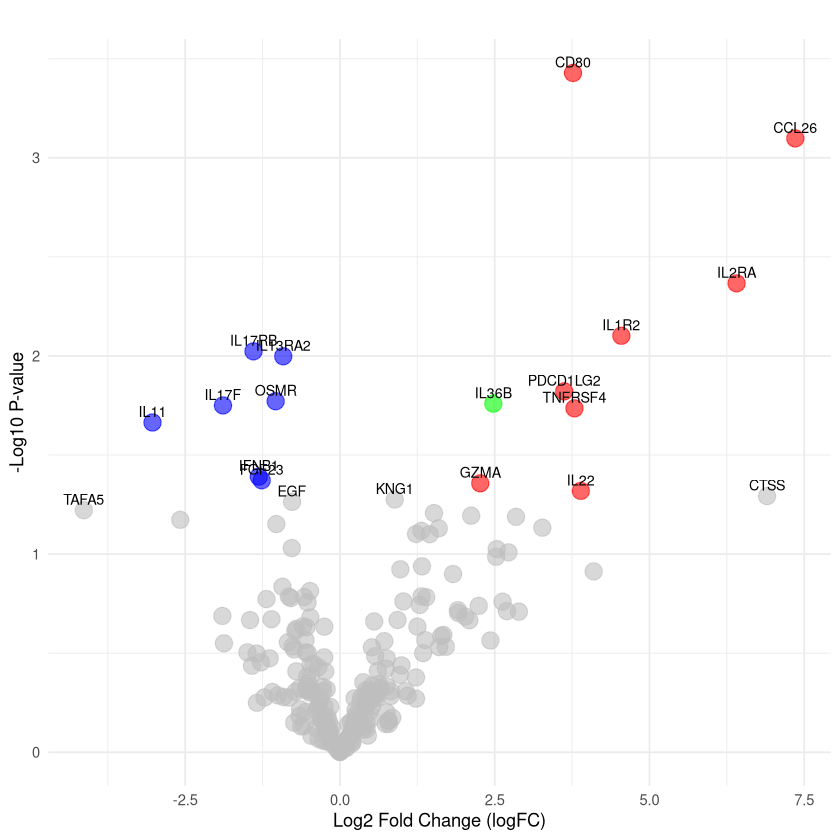

In [14]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_cd.png")
p <- create_volcano_plot_v2(results_cd, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

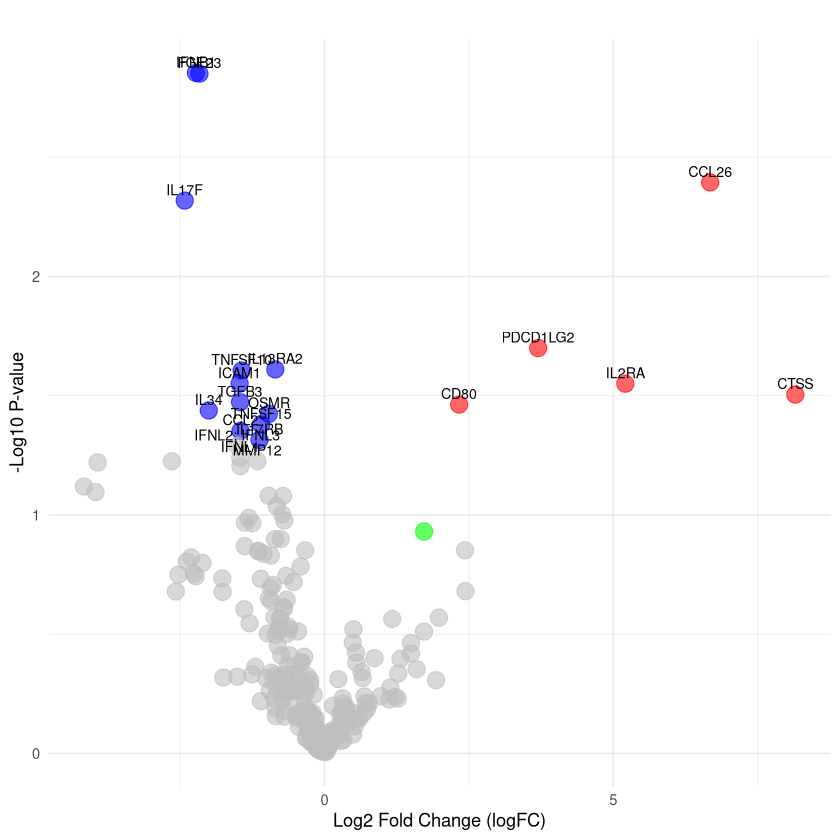

In [15]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_uc.png")
p <- create_volcano_plot_v2(results_uc, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

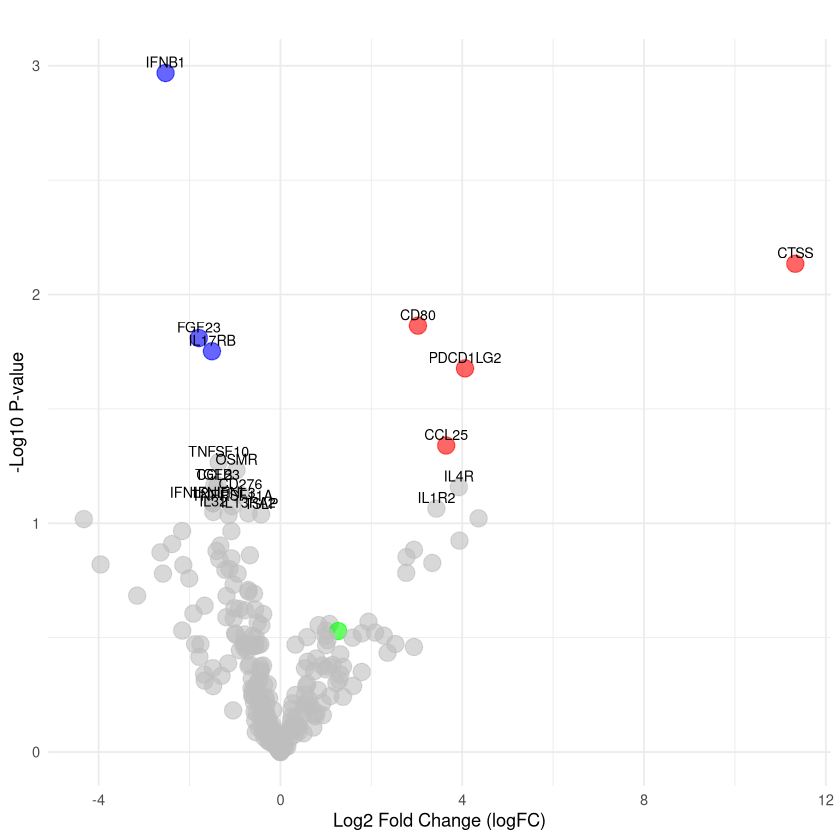

In [16]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_ibdu.png")
p <- create_volcano_plot_v2(results_ibdu, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

In [17]:
# Draw venn diagram of results
#vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

### Run limma with UC versus CD

In [18]:
# set groups and design
group <- factor(clinical_data$ibd_diagnosis, levels=c("CD", "UC", "IBD-U", "Control"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_uc <- topTable(fit, adjust="BH", coef="groupUC", number=Inf)
results_ibdu <- topTable(fit, adjust="BH", coef="groupIBD-U", number=Inf)

# write the data frame to an Excel file
fn = file.path(outdir, "limma.all_data.ibd_subtypes.crohns_versus_uc.xlsx")
write.xlsx(results_uc, fn, asTable = TRUE, rowNames=TRUE)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

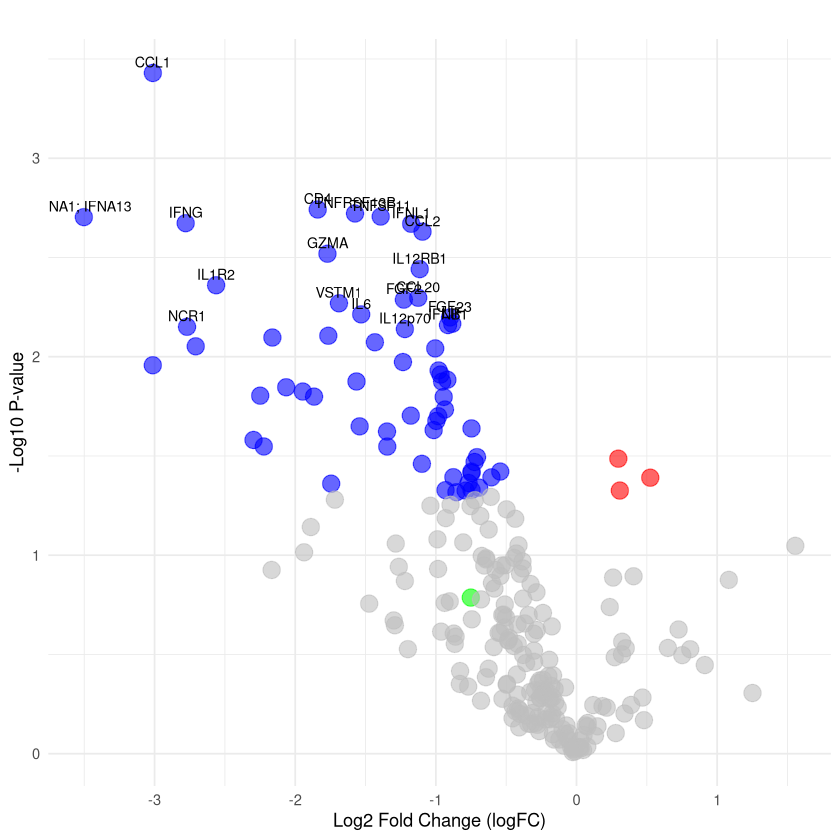

In [19]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_ibdu.png")
fn = file.path(outdir, "test.png")
p <- create_volcano_plot_v2(results_uc, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

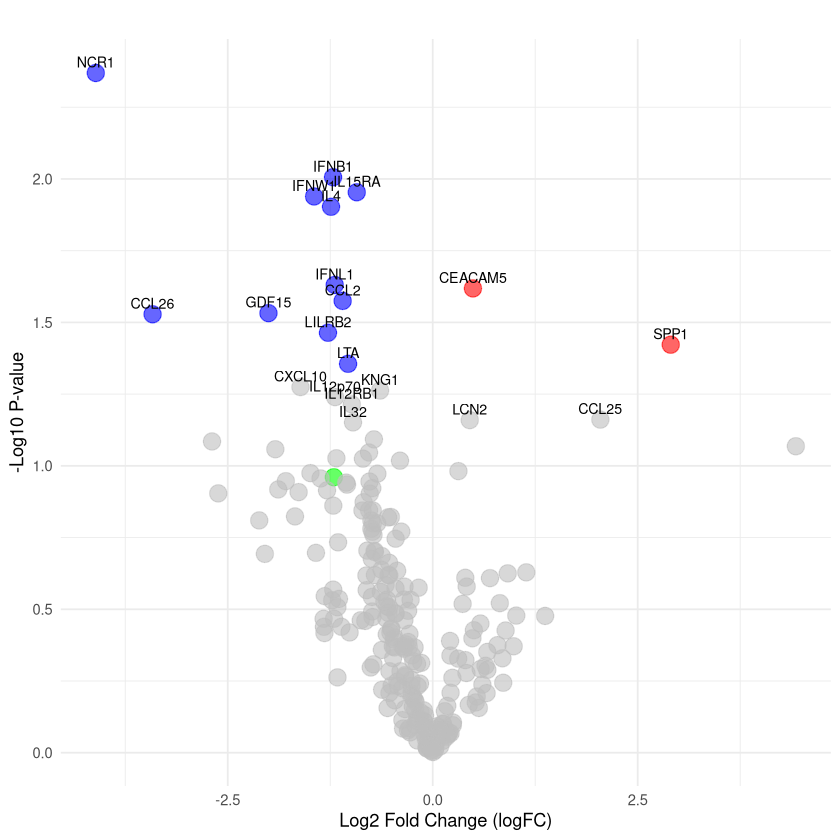

In [20]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_ibdu.png")
fn = file.path(outdir, "test.png")
p <- create_volcano_plot_v2(results_ibdu, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

### Run limma with quiescent crohns versus quiescent ulcerative colitis

In [ ]:
clinical_data$da_and_ibd_diag <- paste(clinical_data$disease_activity, clinical_data$ibd_diagnosis, sep="+")

In [ ]:
unique(clinical_data$da_and_ibd_diag)

[1] "Quiescent+CD"                  "Quiescent+UC"                 
 [3] "Moderate+UC"                   "Mild+CD"                      
 [5] "Quiescent+IBD-U"               "Mild+IBD-U"                   
 [7] "Mild+UC"                       "N/A (Non-IBD Control)+Control"
 [9] "Moderate+IBD-U"                "Moderate+CD"

In [ ]:
# set groups and design
group <- factor(clinical_data$da_and_ibd_diag, levels=c("Quiescent+CD", "Quiescent+UC", "Moderate+UC", "Mild+CD", "Quiescent+IBD-U", "Mild+IBD-U", "Mild+UC", "N/A (Non-IBD Control)+Control", "Moderate+IBD-U", "Moderate+CD"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_uc <- topTable(fit, adjust="BH", coef="groupQuiescent+UC", number=Inf)

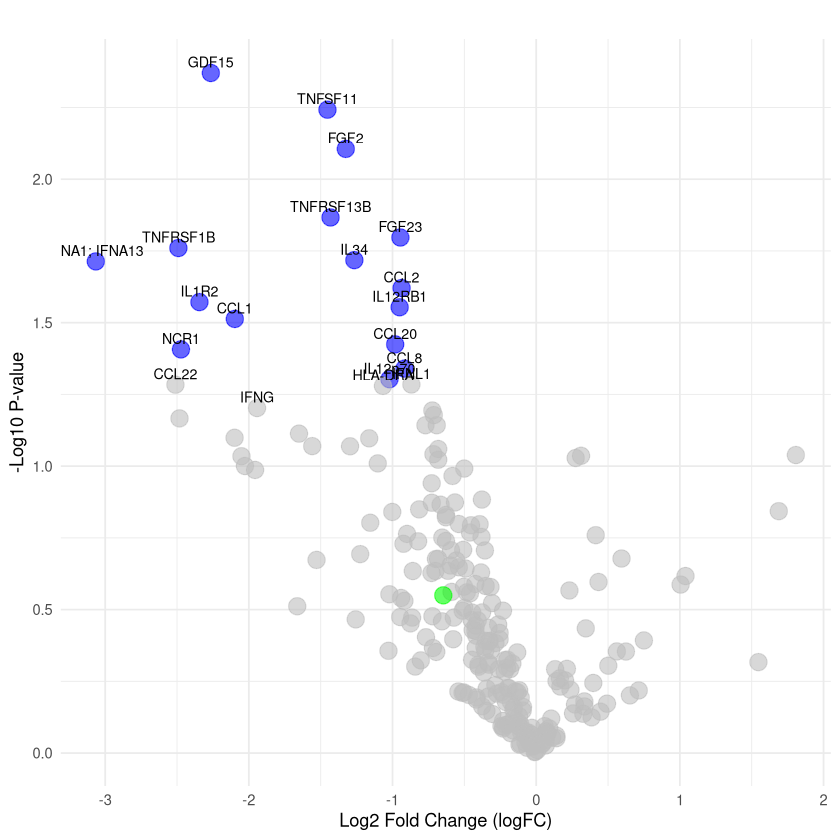

In [ ]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_ibdu.png")
fn = file.path(outdir, "test.png")
p <- create_volcano_plot_v2(results_uc, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

### Run limma with active crohns versus active ulcerative colitis versus

In [ ]:
# add combo column
clinical_data$da_indicator_and_ibd_diag <- paste(clinical_data$disease_activity_indicator, clinical_data$ibd_diagnosis, sep="+")

# set groups and design
clevels <- c('Active Disease+CD', 'Active Disease+UC', 'Active Disease+IBD-U',
                'In-active Disease+CD', 'In-active Disease+UC', 'In-active Disease+IBD-U', 'In-active Disease+Control')
group <- factor(clinical_data$da_indicator_and_ibd_diag, levels=clevels)
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_uc <- topTable(fit, adjust="BH", coef="groupActive Disease+UC", number=Inf)

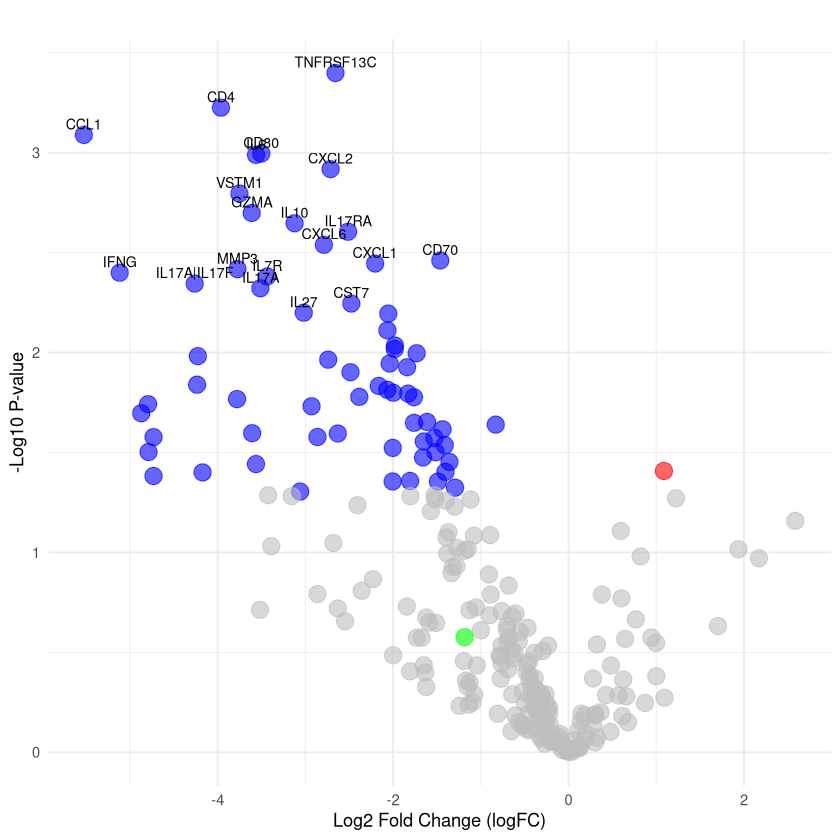

In [ ]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_ibdu.png")
fn = file.path(outdir, "test.png")
p <- create_volcano_plot_v2(results_uc, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

## Run limma for disease activity (all data)

In [ ]:
# set groups and design
group <- factor(clinical_data$disease_activity, levels=da_levels)
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_qu <- topTable(fit, adjust="BH", coef="groupQuiescent", number=Inf)
#results_qu <- cbind(protein=rownames(results_qu), results_qu)

results_mild <- topTable(fit, adjust="BH", coef="groupMild", number=Inf)
#results_mild <- cbind(protein=rownames(results_mild), results_mild)

results_mod <- topTable(fit, adjust="BH", coef="groupModerate", number=Inf)
#results_mod <- cbind(protein=rownames(results_mod), results_mod)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

In [ ]:
outfn = file.path(outdir, "limma.all_data.disease_activity.control_versus_quiescent.tsv")
write.table(results_qu, file = outfn, sep="\t", col.names=TRUE, quote=FALSE)

outfn = file.path(outdir, "limma.all_data.disease_activity.control_versus_mild.tsv")
write.table(results_mild, file = outfn, sep="\t", col.names=TRUE, quote=FALSE)

outfn = file.path(outdir, "limma.all_data.disease_activity.control_versus_moderate.tsv")
write.table(results_mod, file = outfn, sep="\t", col.names=TRUE, quote=FALSE)

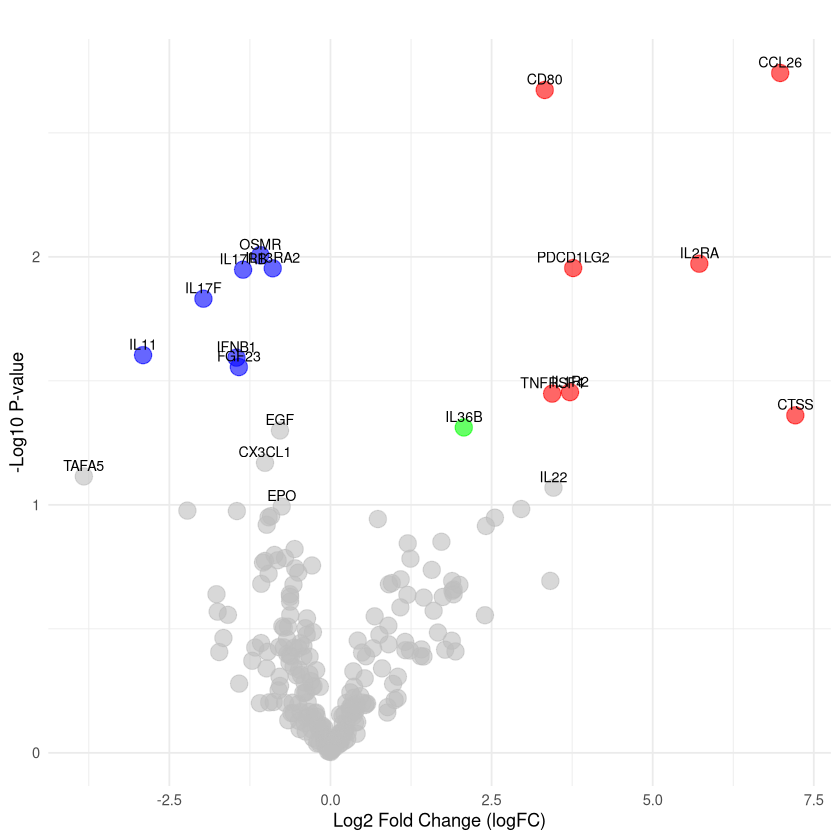

In [ ]:
fn = file.path(outdir, "limma.all_data.disease_activity.control_versus_quiescent.png")
p <- create_volcano_plot_v2(results_qu, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

In [ ]:
data.matrix(results_qu["IL36B",])

,logFC,AveExpr,t,P.Value,adj.P.Val,B
IL36B,2.068974,16.51681,1.999649,0.04874689,0.783717,-3.899557


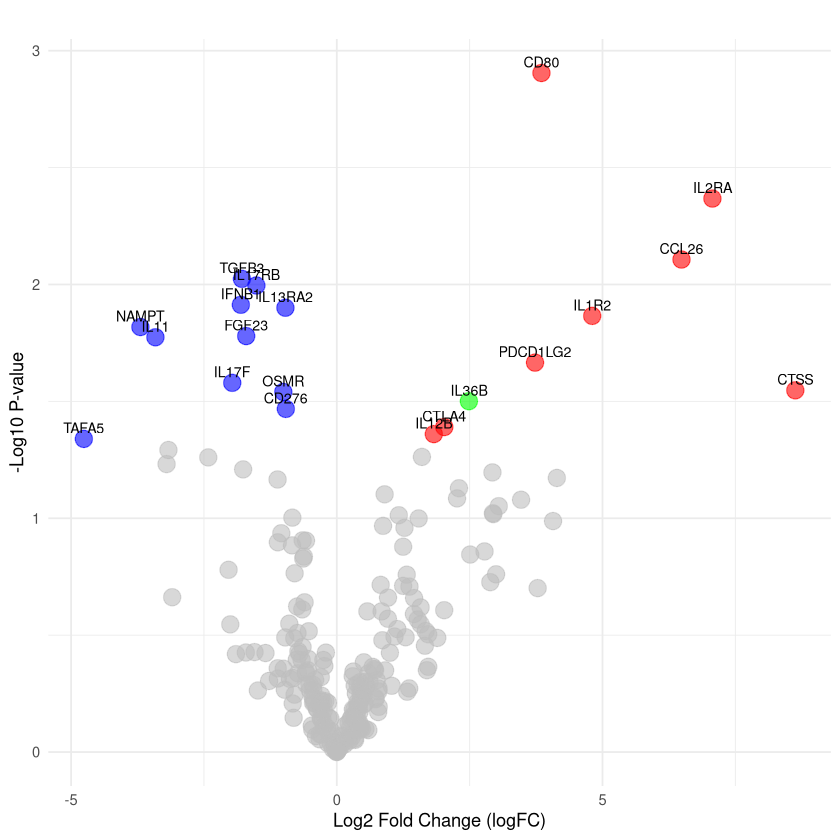

In [ ]:
fn = file.path(outdir, "limma.all_data.disease_activity.control_versus_mild.png")
p <- create_volcano_plot_v2(results_mild, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

In [ ]:
data.matrix(results_mild["IL36B",])

,logFC,AveExpr,t,P.Value,adj.P.Val,B
IL36B,2.485836,16.51681,2.186126,0.03156864,0.49326,-3.535511


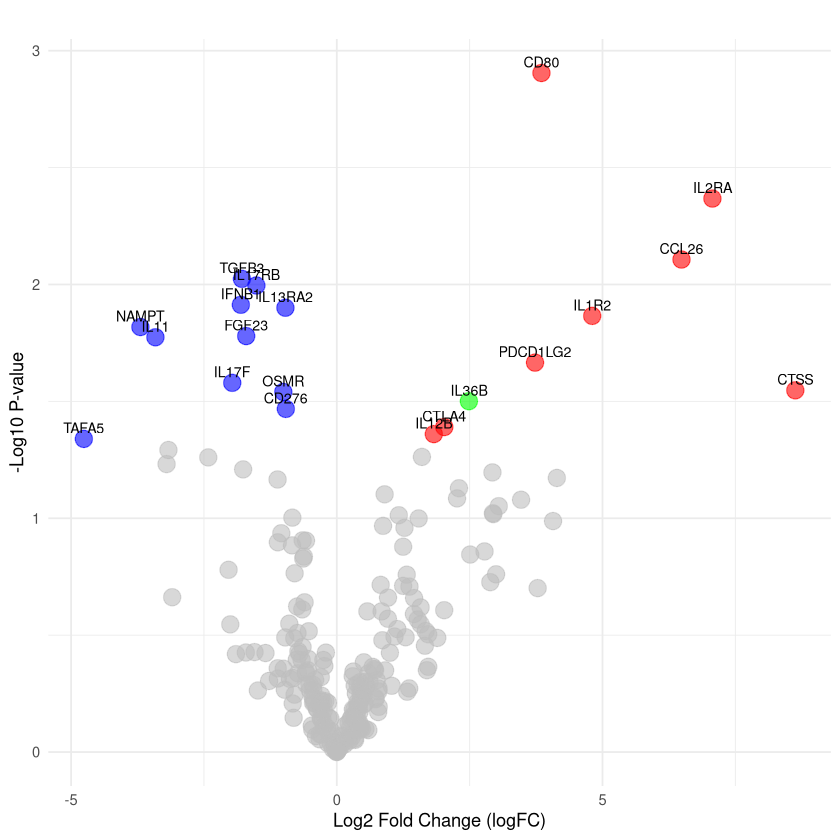

In [ ]:
fn = file.path(outdir, "limma.all_data.disease_activity.control_versus_moderate.png")
p <- create_volcano_plot_v2(results_mild, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

In [ ]:
data.matrix(results_mod["IL36B",])

,logFC,AveExpr,t,P.Value,adj.P.Val,B
IL36B,2.812835,16.51681,2.172675,0.03260153,0.9934137,-3.55652


### Indicator version

In [ ]:
# Draw venn diagram of results
# vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

In [ ]:
# set groups and design
group <- factor(clinical_data$disease_activity_indicator, levels=c("In-active Disease", "Active Disease"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_da <- topTable(fit, adjust="BH", coef="groupActive Disease", number=Inf)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

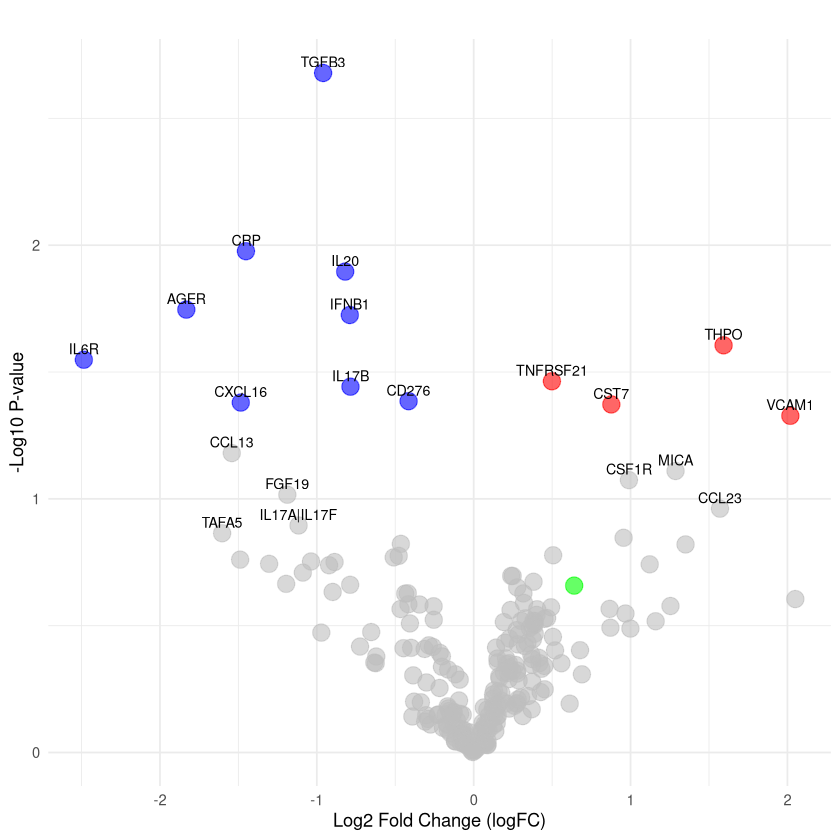

In [ ]:
fn = file.path(outdir, "limma.all_data.disease_activity_indicator.inactive_versus_active.png")
p <- create_volcano_plot_v2(results_da, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

# Draw venn diagram of results
# vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

### Investigating Protein Levels One at a Time

In [ ]:
temp_protein_data <- t(protein_data)
combined_data = data.frame(temp_protein_data, disease_activity=factor(clinical_data$disease_activity, levels=da_levels))

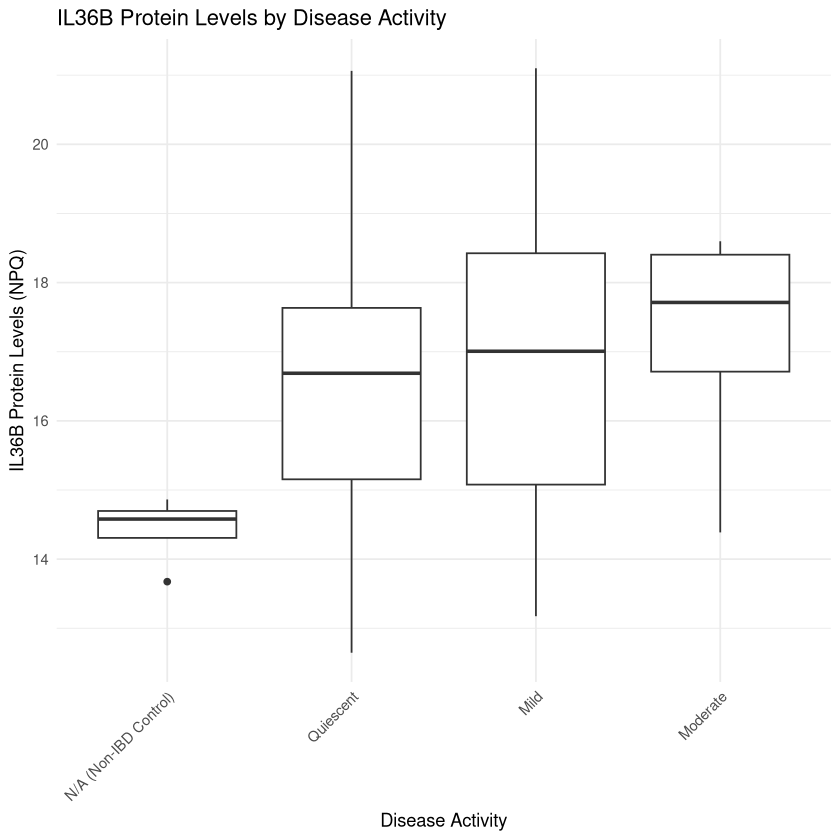

In [ ]:
# Create the boxplot
ggplot(combined_data, aes(x=disease_activity, group = disease_activity, y = IL36B)) +
  geom_boxplot() +
  labs(title = "IL36B Protein Levels by Disease Activity",
       x = "Disease Activity",
       y = "IL36B Protein Levels (NPQ)") +
  theme_minimal() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1))


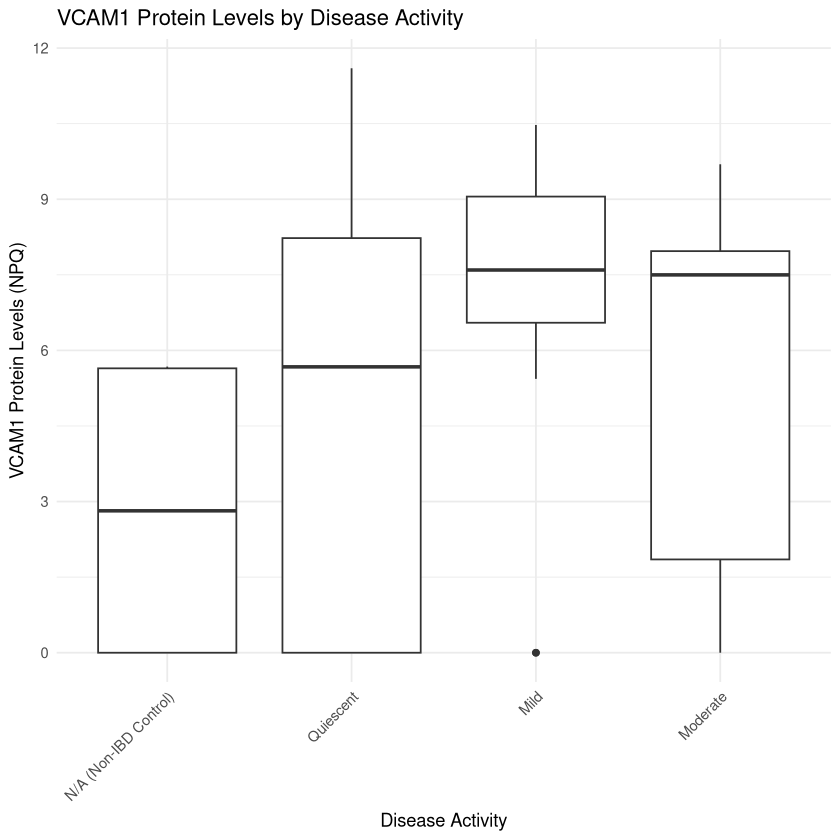

In [ ]:
# Create the boxplot
ggplot(combined_data, aes(x=disease_activity, group = disease_activity, y = VCAM1)) +
  geom_boxplot() +
  labs(title = "VCAM1 Protein Levels by Disease Activity",
       x = "Disease Activity",
       y = "VCAM1 Protein Levels (NPQ)") +
  theme_minimal() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Run limma for disease activity indicator with CD data only

In [ ]:
crohn_clinical_data <- clinical_data[clinical_data$ibd_diagnosis == "CD",]
crohn_protein_data <- protein_data[, crohn_clinical_data$sample_id]

# set groups and design
group <- factor(crohn_clinical_data$disease_activity_indicator, levels=c("In-active Disease", "Active Disease"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(crohn_protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_da <- topTable(fit, adjust="BH", coef="groupActive Disease", number=Inf)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)


### Visualize the results

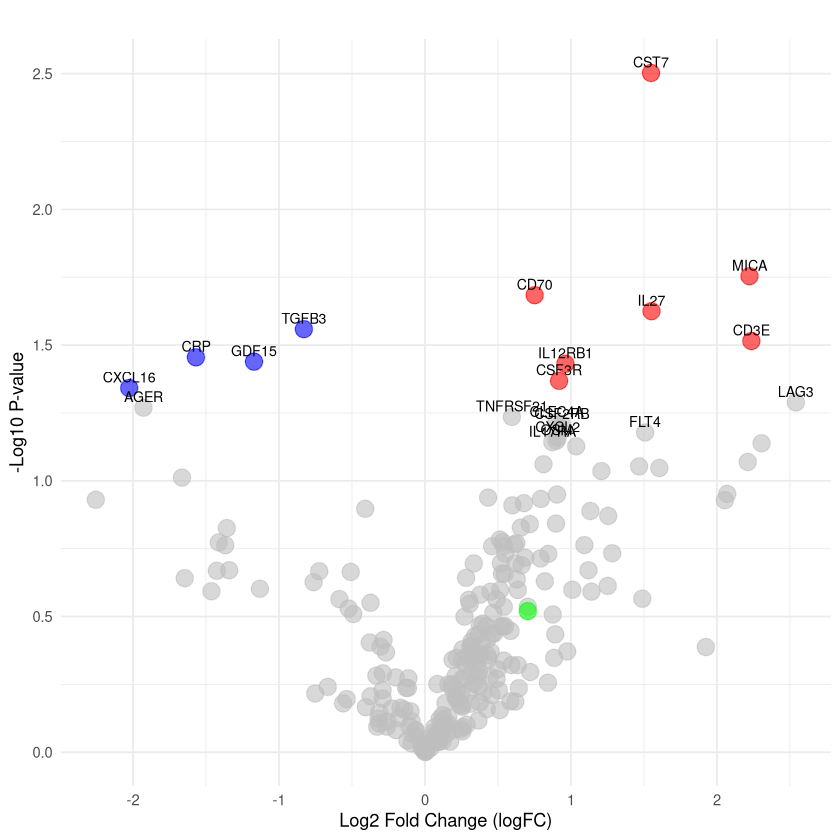

In [ ]:
fn = file.path(outdir, "limma.crohn_data.disease_activity_indicator.inactive_versus_active.png")
p <- create_volcano_plot_v2(results_da, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

# Draw venn diagram of results
# vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

## Run Limma for disease activity indicator with UC data only

In [ ]:
uc_clinical_data <- clinical_data[clinical_data$ibd_diagnosis == "UC",]
uc_protein_data <- protein_data[, uc_clinical_data$sample_id]

# set groups and design
group <- factor(uc_clinical_data$disease_activity_indicator, levels=c("In-active Disease", "Active Disease"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(uc_protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_da <- topTable(fit, adjust="BH", coef="groupActive Disease", number=Inf)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

### Visualize the results

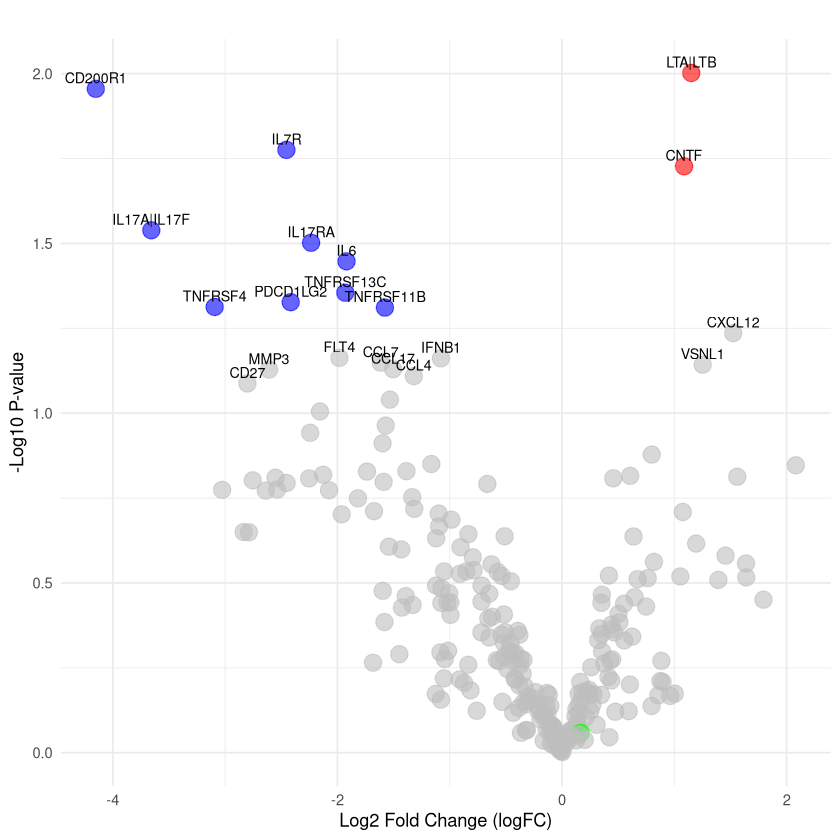

In [ ]:
fn = file.path(outdir, "limma.ulcerative_colitis_data.disease_activity_indicator.inactive_versus_active.png")
p <- create_volcano_plot_v2(results_da, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

# Draw venn diagram of results
#vennDiagram(decideTests(fit, method="global", adjust.method="BH"))